In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

1. Look at the big picture.
2. Get the data.
3. Discover and visualize the data to gain insights.
4. Prepare the data for Machine Learning algorithms.
5. Select a model and train it.
6. Fine-tune your model.
7. Present your solution.
8. Launch, monitor, and maintain your system.

# 1. Look at the big picture

### Understanding the data (Fire Weather Index(FWI) in 2000)
1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: 'jan' to 'dec'
4. day - day of the week: 'mon' to 'sun'
5. FFMC - FFMC(Fine Fuel Moisture Code) index from the FWI system: 18.7 to 96.20
6. DMC - DMC(Duff Moisture Code) index from the FWI system: 1.1 to 291.3 
7. DC - DC(Drought Code) index from the FWI system: 7.9 to 860.6 
8. ISI - ISI(Initial Spread) index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 
   (this output variable is very skewed towards 0.0, thus it may make
    sense to model with the logarithm transform).

### Objective:  
Predict the burned area of forest fires (in hectares) in the northeast region of Portugal based on weather conditions(meterological) and fire danger indices.  
### Key Considerations:  
Type of Problem: Supervised learning, specifically a regression task.  
Multivariate regression problem since the system will use multiple features to make a prediction.  
The data is small enough to fit in memory, so plain batch learning should do just fine

# 2. Get the data

In [2]:
# Dataset - https://archive.ics.uci.edu/dataset/162/forest+fires
column_dtype={ # defining dtypes helps in memory optimization
    "X": "int16",
    "Y": "int16",
    "RH": "int16",
    "month": "category",
    "day": "category",
    "FFMC": "float16",
    "DMC": "float16",
    "DC": "float32",
    "ISI": "float16",
    "temp": "float16",
    "rain": "float16",
    "area": "float16",   
}
df = pd.read_csv("datasets/forest+fires/forestfires.csv", dtype=column_dtype)
df.shape

(517, 13)

In [3]:
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.1875,26.203125,94.300003,5.101562,8.203125,51,6.7,0.000000,0.0
1,7,4,oct,tue,90.6250,35.406250,669.099976,6.699219,18.000000,33,0.9,0.000000,0.0
2,7,4,oct,sat,90.6250,43.687500,686.900024,6.699219,14.601562,33,1.3,0.000000,0.0
3,8,6,mar,fri,91.6875,33.312500,77.500000,9.000000,8.296875,97,4.0,0.199951,0.0
4,8,6,mar,sun,89.3125,51.312500,102.199997,9.601562,11.398438,99,1.8,0.000000,0.0


In [4]:
mem_usage = df.memory_usage(deep=True)
mem_usage.sum()

np.int64(18412)

In [5]:
df.info() # No NaNs in our data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   X       517 non-null    int16   
 1   Y       517 non-null    int16   
 2   month   517 non-null    category
 3   day     517 non-null    category
 4   FFMC    517 non-null    float16 
 5   DMC     517 non-null    float16 
 6   DC      517 non-null    float32 
 7   ISI     517 non-null    float16 
 8   temp    517 non-null    float16 
 9   RH      517 non-null    int16   
 10  wind    517 non-null    float64 
 11  rain    517 non-null    float16 
 12  area    517 non-null    float16 
dtypes: category(2), float16(6), float32(1), float64(1), int16(3)
memory usage: 17.0 KB


In [6]:
df.describe() 

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.687500,110.875000,547.940063,9.023438,18.890625,44.288201,4.017602,0.021652,12.851562
std,2.313778,1.229900,5.519531,64.000000,248.066193,4.558594,5.808594,16.317469,1.791653,0.295898,63.656250
min,1.000000,2.000000,18.703125,1.099609,7.900000,0.000000,2.199219,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.187500,68.625000,437.700012,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.625000,108.312500,664.200012,8.398438,19.296875,42.000000,4.000000,0.000000,0.520020
75%,7.000000,5.000000,92.875000,142.375000,713.900024,10.796875,22.796875,53.000000,4.900000,0.000000,6.570312
max,9.000000,9.000000,96.187500,291.250000,860.599976,56.093750,33.312500,100.000000,9.400000,6.398438,1091.000000


##### Observation:  
for target variable "area"- Large max vs mean (Target or feature has high variance). Skewed  
Rain is another skewed feature - Most days we have no rain (for 75% of data, but max value is 6.3 and 0.02 mean). Huge difference  

# 3. Discover and visualize the data to gain insights

In [7]:
month_mapping = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6,
                 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
day_mapping = {
    'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4,
    'fri': 5, 'sat': 6, 'sun': 7
}

df["month_num"] = df["month"].map(month_mapping).astype(int)
df["day_num"] = df["day"].map(day_mapping).astype(int)

In [8]:
df = df.sort_values(by=["month_num", "day_num"], ascending=True).reset_index(drop=True)
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,month_num,day_num
0,2,4,jan,sat,82.125000,3.699219,9.300000,2.900391,5.300781,78,3.1,0.0,0.000000,1,6
1,4,5,jan,sun,18.703125,1.099609,171.399994,0.000000,5.199219,100,0.9,0.0,0.000000,1,7
2,2,2,feb,mon,84.000000,9.296875,34.000000,2.099609,13.898438,40,5.4,0.0,0.000000,2,1
3,7,4,feb,mon,84.687500,9.500000,58.299999,4.101562,7.500000,71,6.3,0.0,9.960938,2,1
4,6,5,feb,mon,84.125000,4.601562,46.700001,2.199219,5.300781,68,1.8,0.0,0.000000,2,1


In [9]:
df["month_num"].value_counts().sort_index() # Making sure we have complete records from Jan-Dec, 2000

month_num
1       2
2      20
3      54
4       9
5       2
6      17
7      32
8     184
9     172
10     15
11      1
12      9
Name: count, dtype: int64

In [10]:
numeric_cols = df.select_dtypes(include="number").columns.tolist()
for col in ["month_num", "day_num"]:
    numeric_cols.remove(col)
numeric_cols

['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']

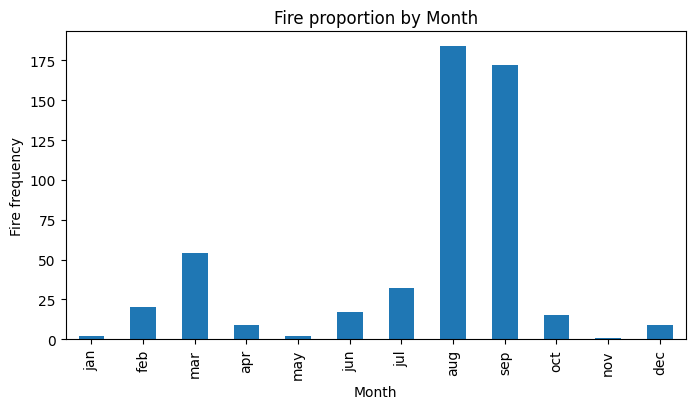

In [11]:
plt.figure(figsize=(8,4))
df["month_num"].value_counts().sort_index().plot(kind="bar")
plt.xticks(ticks=range(12), labels=month_mapping.keys())
plt.title("Fire proportion by Month")
plt.xlabel("Month")
plt.ylabel("Fire frequency")
plt.show()

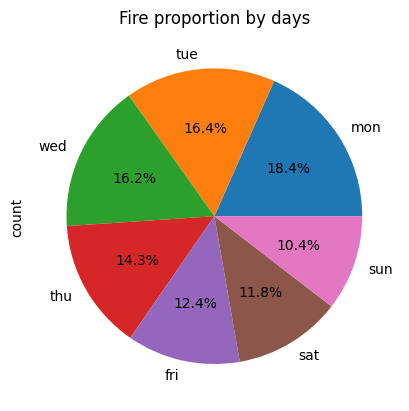

In [12]:
df["day_num"].sort_index().value_counts().plot(kind="pie", autopct='%1.1f%%', labels=day_mapping.keys())
plt.title("Fire proportion by days")
plt.show()

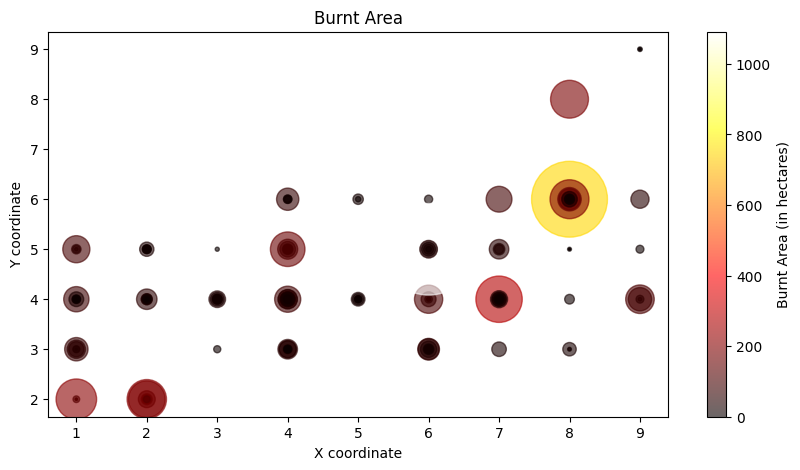

In [13]:
plt.figure(figsize=(10,5))
plt.scatter(x=df["X"], y=df["Y"], s=df["area"]*4, c=df["area"], cmap="hot", alpha=0.6)
plt.colorbar(label='Burnt Area (in hectares)')
plt.title("Burnt Area")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.show()

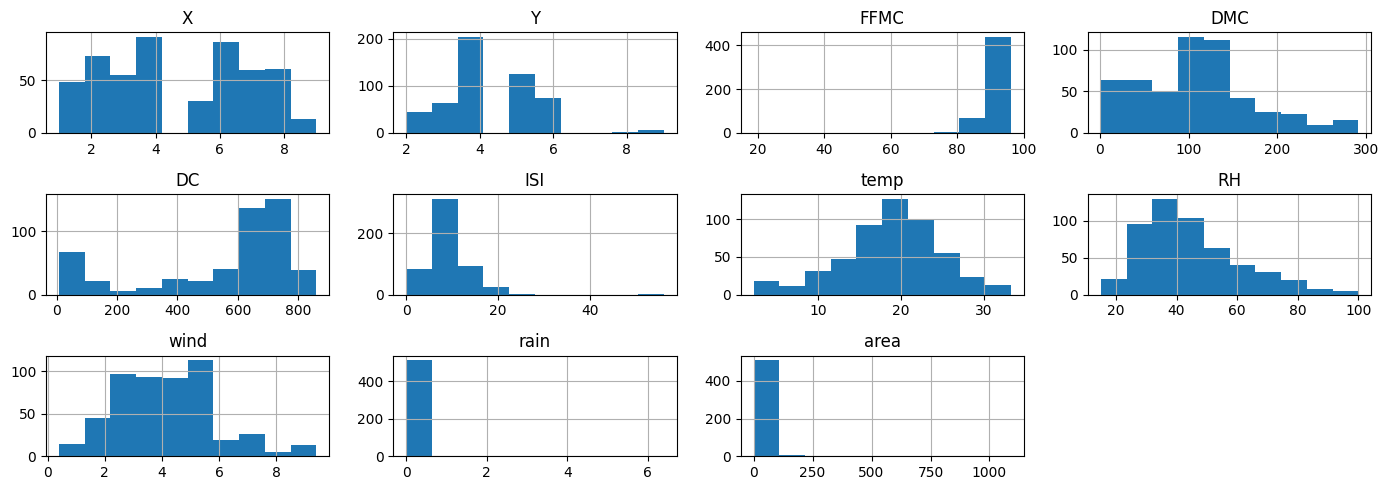

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(14,5))
ax=ax.flatten() # Flatten 2D array to 1D for easy indexing
for i, col in enumerate(numeric_cols):
    df[col].hist(ax=ax[i])
    ax[i].set_title(col)

# remove empty plots
for j in range(i+1, len(ax)):
    fig.delaxes(ax[j])
plt.tight_layout()
plt.show()

##### Observations:  
1. Rain and target "area" are heavily right skewed (as expected).  
2. FFMC is left skewed (long tail on the left end, negative skew)  
3. ISI is right skewed (long tail at the right end, positive skew)  

##### Notes:- What is Skewness?  
Skewness measures the asymmetry of a distribution around its mean.  
0 means perfectly symmetric (like a normal distribution)  
Positive values indicate a right (positive) skew — long tail on the right  
Negative values indicate a left (negative) skew — long tail on the left  

##### Skewness Value | Interpretation  
-0.5 to 0.5	Approximately symmetric  
-1 to -0.5 or 0.5 to 1	Moderate skewness  
< -1 or > 1	Highly skewed

In [15]:
df[numeric_cols].skew() # Shows FFMC & DC as left skewed and rain, area and ISI as right skewed

X        0.036246
Y        0.417296
FFMC    -6.574219
DMC      0.547363
DC      -1.100445
ISI      2.535156
temp    -0.330811
RH       0.862904
wind     0.571001
rain    19.812500
area    12.843750
dtype: float64

### Treating skewed features

In [16]:
right_skewed_cols = ["area", "rain", "ISI"]
left_skewed_cols = ["FFMC", "DC"]

df_transformed = df.copy()

# Strong right-skew → log1p
for col in right_skewed_cols:
    df_transformed[f"{col}_log"] = np.log1p(df_transformed[col])

# Strong left-skew → reflect then log1p
for col in left_skewed_cols:
    df_transformed[f"{col}_log"] = np.log1p(df_transformed[col].max() + 1 - df_transformed[col])

### Visualise skewness fix

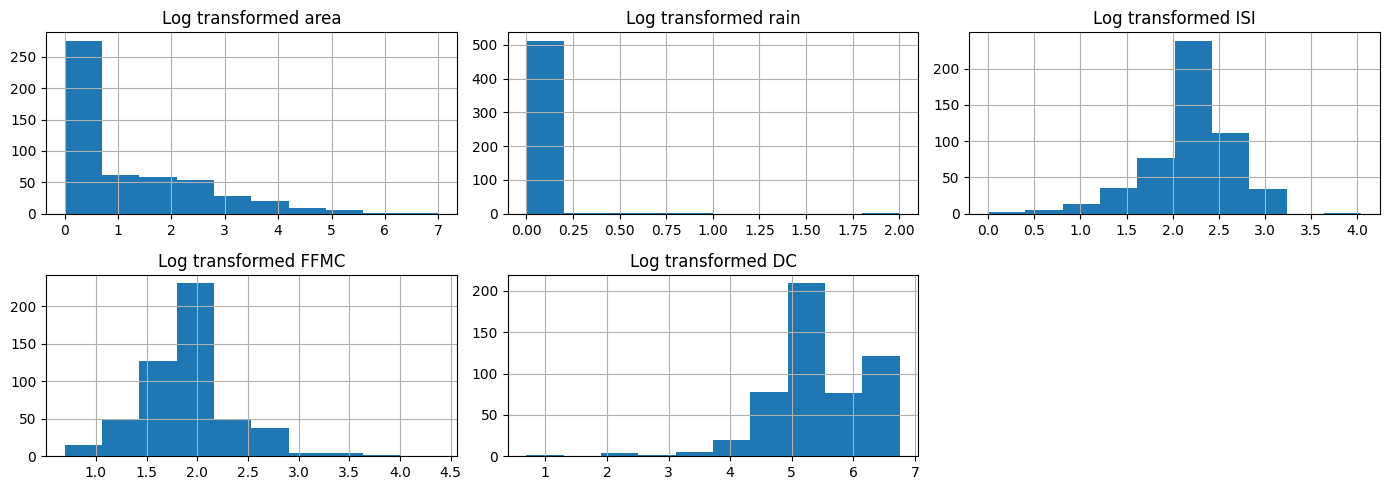

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14,5))
ax=ax.flatten()
for i, col in enumerate(right_skewed_cols + left_skewed_cols):
    df_transformed[f"{col}_log"].hist(ax=ax[i])
    ax[i].set_title(f"Log transformed {col}") # notice the changes in scale

for j in range(i+1, 6):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

In [18]:
for col in right_skewed_cols + left_skewed_cols:
    numeric_cols.append(f"{col}_log")
df_transformed[numeric_cols].skew() # As we can see the parameter "rain" has not significantly improved. Let's investigate further.

X            0.036246
Y            0.417296
FFMC        -6.574219
DMC          0.547363
DC          -1.100445
ISI          2.535156
temp        -0.330811
RH           0.862904
wind         0.571001
rain        19.812500
area        12.843750
area_log     1.217773
rain_log    14.171875
ISI_log     -0.937988
FFMC_log     0.706055
DC_log      -0.770647
dtype: float64

In [19]:
df_transformed["rain_log"].value_counts(), df["rain"].value_counts() # Most values are zero. It's better to bin the 'rain' data and make it categorical

(rain_log
 0.000000    509
 0.182251      2
 0.587891      2
 2.001953      1
 0.336426      1
 0.875488      1
 0.693359      1
 Name: count, dtype: int64,
 rain
 0.000000    509
 0.199951      2
 0.799805      2
 6.398438      1
 0.399902      1
 1.400391      1
 1.000000      1
 Name: count, dtype: int64)

In [20]:
df_transformed["rain_cat"] = pd.cut(df_transformed["rain"].astype("float32"), bins=[-0.01, 0, 1, df_transformed["rain"].max()], labels=["No rain", "light", "heavy"])
df_transformed["rain_cat"].value_counts()

rain_cat
No rain    509
light        6
heavy        2
Name: count, dtype: int64

In [21]:
for col in right_skewed_cols + left_skewed_cols:
    numeric_cols.remove(col)

numeric_cols.remove("rain_log")
numeric_cols

['X',
 'Y',
 'DMC',
 'temp',
 'RH',
 'wind',
 'area_log',
 'ISI_log',
 'FFMC_log',
 'DC_log']

In [22]:
df_transformed.drop(columns="rain_log", inplace=True)

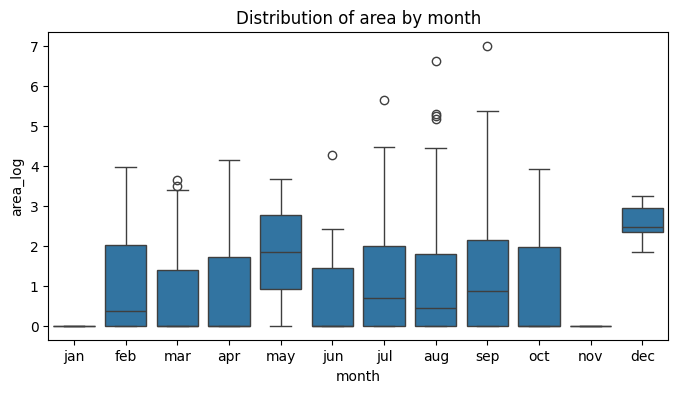

In [23]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df_transformed["month"], y=df_transformed["area_log"], data=df_transformed, order=month_mapping.keys())
plt.title("Distribution of area by month")
plt.show()

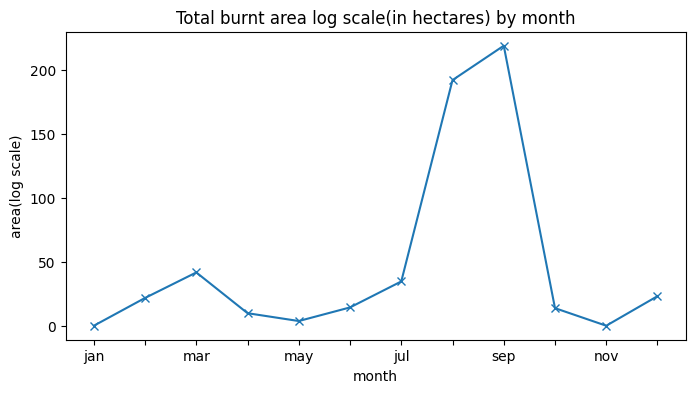

In [24]:
plt.figure(figsize=(8,4))
df_area_by_month = df_transformed.groupby("month")["area_log"].sum()
df_area_by_month = df_area_by_month.reindex(month_mapping.keys()) # to keep order
df_area_by_month.plot(kind="line", marker="x")
plt.xticks(ticks=range(12), label=month_mapping.keys())
plt.title("Total burnt area log scale(in hectares) by month")
plt.ylabel("area(log scale)")
plt.xlabel("month")
plt.show()

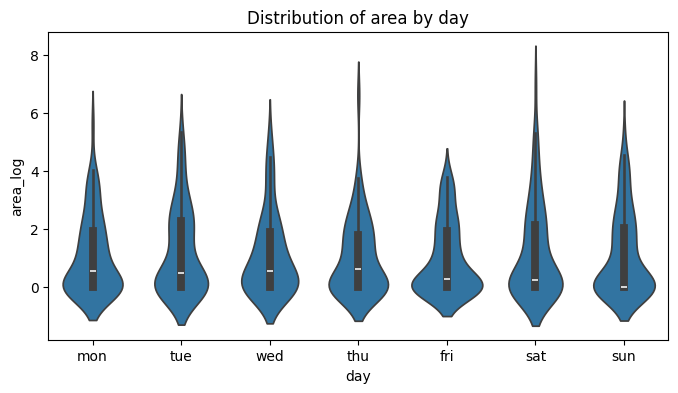

In [25]:
plt.figure(figsize=(8,4))
sns.violinplot(x=df_transformed["day"], y=df_transformed["area_log"], data=df_transformed, order=day_mapping.keys())
plt.title("Distribution of area by day")
plt.show()

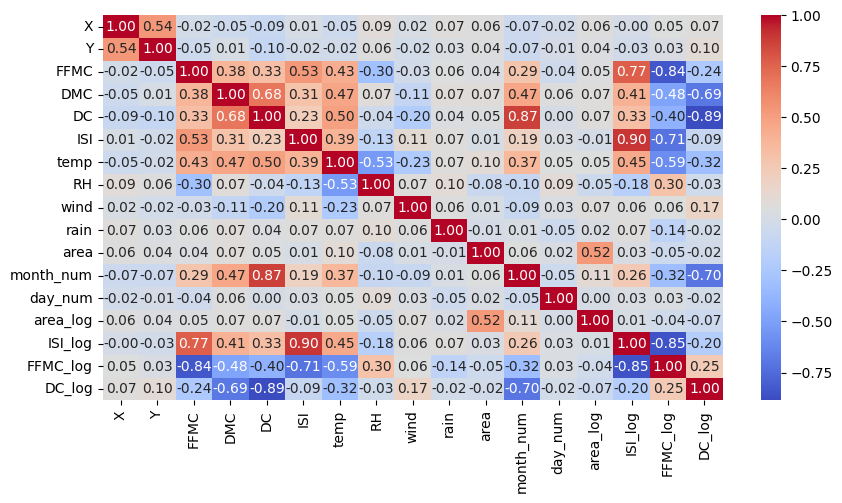

In [26]:
plt.figure(figsize=(10,5))
sns.heatmap(df_transformed.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.show() # We see some strong corelations amongst features, but not with the target.

In [27]:
df_transformed.corr(numeric_only=True)["area_log"].sort_values(ascending=False)

area_log     1.000000
area         0.524121
month_num    0.114284
DMC          0.067142
wind         0.066957
DC           0.066372
X            0.061983
temp         0.053515
FFMC         0.046718
Y            0.038849
rain         0.023332
ISI_log      0.009439
day_num      0.000213
ISI         -0.010355
FFMC_log    -0.035747
RH          -0.053680
DC_log      -0.066463
Name: area_log, dtype: float64

##### Observations:  
Very weak correlations across the board  
Even after log-transforming area, no feature has a correlation > 0.12.  
month_num, DMC, wind, and DC are the top correlations — still weak.
##### Hence, Linear models would struggle as there is no strong single-feature signal.

# Prepare the data for Machine Learning algorithms

##### Feature Engineering

In [28]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["temp_wind"] = X["temp"] * X["wind"] # High temp + wind = fast fire spread
        X["dryness_index"] = X["DMC"] / (X["RH"] + 1) # High DMC & low RH = dry conditions
        X["X_Y"] = X["X"] * X["Y"] # Fire location interaction
        X["wind_logscaled"] = X["wind"] * X["ISI_log"] # Wind relative to scaled spread index
        X = X.drop(columns=["rain", "FFMC", "DC", "ISI", "month_num", "day_num"], errors="ignore")

        return X

In [29]:
df_transformed.columns

Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain', 'area', 'month_num', 'day_num', 'area_log', 'ISI_log',
       'FFMC_log', 'DC_log', 'rain_cat'],
      dtype='object')

##### One Hot Encoding & Feature Scaling Pipelines

In [30]:
categorical_cols = ["month", "day", "rain_cat"]
numeric_cols = ['X', 'Y', 'DMC', 'temp', 'RH', 'temp_wind', 'dryness_index', 'X_Y', 'wind_logscaled',
       'wind', 'ISI_log', 'FFMC_log', 'DC_log']

categorical_pipeline = Pipeline([
    ("onehotencoder", OneHotEncoder(handle_unknown="ignore"))
])

numerical_pipeline = Pipeline([
    ("std_scaler", StandardScaler())
])

preprocessor = ColumnTransformer([
    ("num_pipeline", numerical_pipeline, numeric_cols),
    ("cat_pipeline", categorical_pipeline, categorical_cols)
])

##### Full Modeling Pipeline

In [31]:
full_pipeline = Pipeline([
    ("feature_eng", FeatureEngineer()),
    ("preprocessor", preprocessor),
])

In [32]:
##### Train-Test Split
target = "area_log"
X = df_transformed.copy()
y = df_transformed[target]

X = X.drop(columns=["area_log", "area"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(413, 18) (413,) (104, 18) (104,)


In [33]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.fit_transform(X_test)

In [34]:
X_train_prepared

array([[-1.13154348,  0.59148769,  0.2310819 , ...,  1.        ,
         0.        ,  0.        ],
       [-0.70122354, -0.23659508,  1.10696199, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.45037618,  1.41957045,  2.26945731, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.45037618,  1.41957045,  1.9086829 , ...,  1.        ,
         0.        ,  0.        ],
       [ 1.45037618,  1.41957045, -0.33312919, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.58973629, -0.23659508, -0.36219157, ...,  1.        ,
         0.        ,  0.        ]], shape=(413, 34))

# Select a model and train it

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

##### Linear Model

In [36]:
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()
linear_reg.fit(X_train_prepared, y_train)

LinearRegression()

In [37]:
y_train_predicted = linear_reg.predict(X_train_prepared)
y_test_predicted = linear_reg.predict(X_test_prepared)

In [38]:
print(f"RMSE Train: {np.sqrt(mean_squared_error(y_train, y_train_predicted))}")
print(f"MAE Train: {mean_absolute_error(y_train, y_train_predicted)}")
print(f"R2 Score Train: {r2_score(y_train, y_train_predicted)}")
print(f"RMSE Test: {np.sqrt(mean_squared_error(y_test, y_test_predicted))}")
print(f"MAE Test: {mean_absolute_error(y_test, y_test_predicted)}")
print(f"R2 Score Test: {r2_score(y_test, y_test_predicted)}")

RMSE Train: 1.318792081152333
MAE Train: 1.084925014986673
R2 Score Train: 0.07764652608171163
RMSE Test: 1.4387496703663876
MAE Test: 1.126485693006344
R2 Score Test: 0.06483720424171024


##### Decision Tree Regressor

In [39]:
from sklearn.tree import DecisionTreeRegressor
dec_reg = DecisionTreeRegressor()
dec_reg.fit(X_train_prepared, y_train)

DecisionTreeRegressor()

In [40]:
scores = cross_val_score(dec_reg, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=5)
rmse_dec_scores_train = np.sqrt(-scores)
print(f"RMSE Train: {np.mean(rmse_dec_scores_train)}")

RMSE Train: 2.1016982091455323


In [41]:
y_test_predicted_dec = dec_reg.predict(X_test_prepared)
print(f"RMSE Test: {np.sqrt(mean_squared_error(y_test, y_test_predicted_dec))}") # RMSE_test < RMSE_train, Decision Tree is overfitting!
print(f"MAE Test: {mean_absolute_error(y_test, y_test_predicted_dec)}")
print(f"R2 Score Test: {r2_score(y_test, y_test_predicted_dec)}")

RMSE Test: 1.9762397235003697
MAE Test: 1.3620570256159856
R2 Score Test: -0.7643957198940889


##### Random Forest Regressor

In [42]:
from sklearn.ensemble import RandomForestRegressor
random_forest_reg = RandomForestRegressor()
random_forest_reg.fit(X_train_prepared, y_train)

RandomForestRegressor()

In [43]:
forest_scores = cross_val_score(random_forest_reg, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=5)
rmse_random_forest_scores_train = np.sqrt(-forest_scores)
print(f"RMSE Train: {np.mean(rmse_random_forest_scores_train)}")

RMSE Train: 1.4592989951577464


In [44]:
y_test_predicted_random_forest = random_forest_reg.predict(X_test_prepared)
print(f"RMSE Test: {np.sqrt(mean_squared_error(y_test, y_test_predicted_random_forest))}")
print(f"MAE Test: {mean_absolute_error(y_test, y_test_predicted_random_forest)}")
print(f"R2 Score Test: {r2_score(y_test, y_test_predicted_random_forest)}")

RMSE Test: 1.4729151406222363
MAE Test: 1.213444542518029
R2 Score Test: 0.019895915002194675


##### Interpretation of results

###### R² Score (Coefficient of Determination)  
Measures how much of the target's variance is explained by the model.  
0.065 (Linear Regression): Explains 6.5% of the variance — still low.  
Negative R² (Decision Tree): Worse than just predicting the mean of the target for every instance — that's a red flag.

##### RMSE / MAE
Error metrics based on log(area) (since our target is log(area)).  
Lower is better.  
RF and DT perform worse than linear regression on both.  

##### Considering Random Forest Scores:  
R² Score = 0.019 → The model explains less than 2% of the variance in the target. This is very low, but at least not negative.  
RMSE = 1.481 (log scale) → On average, the predictions deviate from actual values by this much on the log(area) scale.  
MAE = 1.218 (log scale) → On average, absolute errors in predictions are ~1.2 log points.  

In [45]:
print(f"Random forest RMSE scores suggest that {np.round(np.exp(1.47),2)} hectares i.e. our prediction is off by a multiplicative factor of ~ {np.round(np.exp(1.47),2)} in area")
print(f"Decision Tree RMSE scores suggest that {np.round(np.exp(1.92),2)} hectares i.e. our prediction is off by a multiplicative factor of ~ {np.round(np.exp(1.92),2)} in area")
print(f"Linear Regression RMSE scores suggest that {np.round(np.exp(1.43),2)} hectares i.e. our prediction is off by a multiplicative factor of ~ {np.round(np.exp(1.43),2)} in area")

Random forest RMSE scores suggest that 4.35 hectares i.e. our prediction is off by a multiplicative factor of ~ 4.35 in area
Decision Tree RMSE scores suggest that 6.82 hectares i.e. our prediction is off by a multiplicative factor of ~ 6.82 in area
Linear Regression RMSE scores suggest that 4.18 hectares i.e. our prediction is off by a multiplicative factor of ~ 4.18 in area


##### XGBoost Regression

In [46]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(
    n_estimators=3,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_reg.fit(X_train_prepared, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=3,
             n_jobs=None, num_parallel_tree=None, ...)

In [47]:
y_test_predicted_xgb = xgb_reg.predict(X_test_prepared)
print(f"RMSE Test: {np.sqrt(mean_squared_error(y_test, y_test_predicted_xgb))}")
print(f"MAE Test: {mean_absolute_error(y_test, y_test_predicted_xgb)}")
print(f"R2 Score Test: {r2_score(y_test, y_test_predicted_xgb)}")

RMSE Test: 1.4880782662286682
MAE Test: 1.2199444770812988
R2 Score Test: -0.0003876686096191406


# Fine-tune your model

##### Hyper parameter tuning - Grid Search

In [48]:
param_grid = [
    {'n_estimators': [30, 100 ,200], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [50, 100, 200], 'max_features': [2, 3, 4]}
]

grid_search_cv = GridSearchCV(random_forest_reg, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search_cv.fit(X_train_prepared, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [30, 100, 200]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [50, 100, 200]}],
             scoring='neg_mean_squared_error')

In [49]:
cv_res = grid_search_cv.cv_results_
for mean_score, params in zip(cv_res["mean_test_score"], cv_res["params"]):
    print(np.sqrt(-mean_score), params)

1.4246993430622021 {'max_features': 2, 'n_estimators': 30}
1.423444798945372 {'max_features': 2, 'n_estimators': 100}
1.4259140094473808 {'max_features': 2, 'n_estimators': 200}
1.4529334973050743 {'max_features': 4, 'n_estimators': 30}
1.434995486574798 {'max_features': 4, 'n_estimators': 100}
1.4299336428576679 {'max_features': 4, 'n_estimators': 200}
1.45923318288388 {'max_features': 6, 'n_estimators': 30}
1.4351458076653099 {'max_features': 6, 'n_estimators': 100}
1.439539484186603 {'max_features': 6, 'n_estimators': 200}
1.4593104874632243 {'max_features': 8, 'n_estimators': 30}
1.4518063605520473 {'max_features': 8, 'n_estimators': 100}
1.4423822296900768 {'max_features': 8, 'n_estimators': 200}
1.4829588775063152 {'bootstrap': False, 'max_features': 2, 'n_estimators': 50}
1.455600766049671 {'bootstrap': False, 'max_features': 2, 'n_estimators': 100}
1.4625168474002816 {'bootstrap': False, 'max_features': 2, 'n_estimators': 200}
1.4750561837251326 {'bootstrap': False, 'max_featur

In [50]:
best_model = grid_search_cv.best_estimator_
y_test_predicted_random_forest = best_model.predict(X_test_prepared)
print(best_model)

RandomForestRegressor(max_features=2)


In [51]:
print(f"RMSE Test: {np.sqrt(mean_squared_error(y_test, y_test_predicted_random_forest))}")
print(f"MAE Test: {mean_absolute_error(y_test, y_test_predicted_random_forest)}")
print(f"R2 Score Test: {r2_score(y_test, y_test_predicted_random_forest)}")

RMSE Test: 1.475941718754796
MAE Test: 1.1872887432391828
R2 Score Test: 0.015863898246284758


##### Randomized Search CV

In [52]:
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    RandomForestRegressor(),
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)
random_search.fit(X_train_prepared, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   scoring='neg_mean_squared_error')

In [53]:
cv_res = random_search.cv_results_
for mean_score, params in zip(cv_res["mean_test_score"], cv_res["params"]):
    print(np.sqrt(-mean_score), params)

1.436375554405128 {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 30}
1.4370231509012057 {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10}
1.445181282706672 {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
1.4417792610757334 {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30}
1.4632424101891226 {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}
1.45078007749236 {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
1.442634755528415 {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10}
1.4368445019662321 {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20}
1.4459540882957538 {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 20}
1.4572796840505995 {'n_estimators': 200, 'min_samples_split

In [54]:
best_model = random_search.best_estimator_
y_test_predicted_random_forest = best_model.predict(X_test_prepared)
print(best_model)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=200)


In [55]:
print(f"RMSE Test: {np.sqrt(mean_squared_error(y_test, y_test_predicted_random_forest))}")
print(f"MAE Test: {mean_absolute_error(y_test, y_test_predicted_random_forest)}")
print(f"R2 Score Test: {r2_score(y_test, y_test_predicted_random_forest)}")

RMSE Test: 1.4756632649886492
MAE Test: 1.1975346644003526
R2 Score Test: 0.01623520092085129
